The first attempt with GANs. In this notebook, I introduce, a "traditional" GAN which generates signals in the time domain, the limeGAN that generates signals in the frequency domain, as explained in the report. I also introduce the anoGAN and the f-anoGAN

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/'My Drive'/Internship/Project

Mounted at /content/gdrive/
/content/gdrive/My Drive/Internship/Project


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from pickle import load, dump
from scipy.optimize import minimize

from tensorflow.keras.layers import  LeakyReLU, ReLU, PReLU, Activation, Dropout, BatchNormalization, Dense, \
                                  Input, Conv1D, MaxPool1D, AveragePooling1D, Flatten, LSTM, Reshape, Conv1DTranspose
from tensorflow.keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import Progbar
from tensorflow.keras.constraints import Constraint
import tensorflow as tf

In [3]:
%run Code/Final/DataPreparation.ipynb

In [4]:
%run Code/Final/Performance_metrics.ipynb

In [25]:
%run Code/Final/GANs.ipynb

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


*LimeGAN*

In [6]:
# Example data
s = 1000000
data = np.sin(np.arange(0, s, 0.1)) * np.cos(np.arange(0, s, 0.1)) + np.random.normal(0, 0.1, size=len(np.arange(0, s, 0.1)))
data = np.reshape(data, newshape=(-1, 500, 1))
data_freq = signal_2_fourier(data)

In [7]:
singan = limeGAN(kernel=5, gen_layers=2, dis_layers=2, latentDim=100, depth=20, dil=1, snippet_len=500, 
                  channels=1, dropout=0.3, INIT_LR=1e-5, DECAY=6e-8)

In [25]:
singan.train(data_freq, epochs=150, batch_size=256, smoothen_labels=0)

77/78 [============================>.] - ETA: 10s EPOCH 149: [D loss: 0.791890, acc: 0.480469]   [A loss: 0.537514, acc: 0.746094]


In [8]:
# singan.save('Models/Final/limeGAN')
# singan = limeGAN.load('Models/Final/limeGAN')

In [9]:
fake = singan.generate_fake_signals(10)

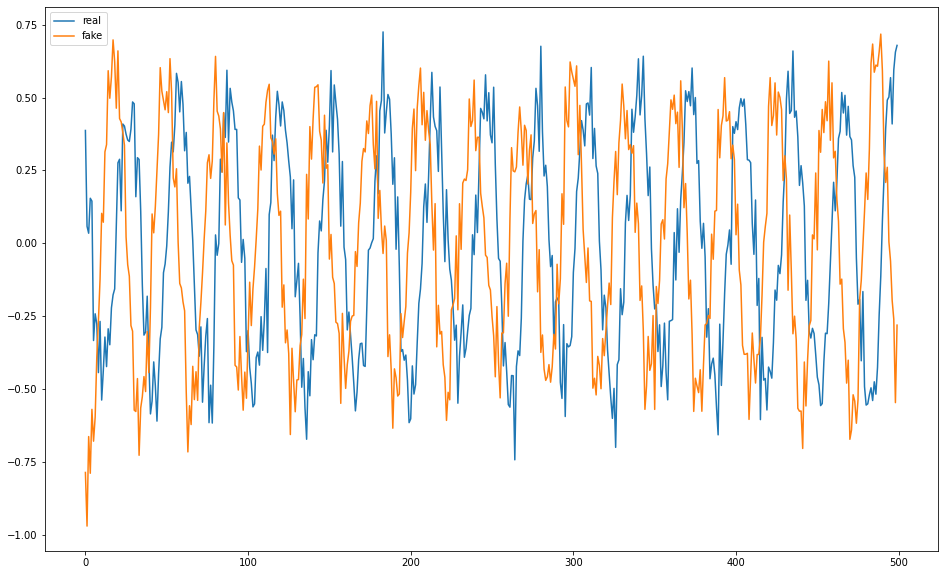

In [10]:
plt.figure(figsize=(16,10))
id = 7
plt.plot(np.arange(500), data[id,:,0], label='real')
plt.plot(np.arange(500), fake[id,:, 0], label='fake') 
plt.legend()
plt.show()

*fanoGAN*

In [31]:
fanogan = FANOGAN(singan, freq=True)

In [32]:
fanogan.build_encoder(kernel=5, layers=2, dropout=0.3)

In [15]:
d_train, d_val = data_freq[:int(data_freq.shape[0]*0.8)], data_freq[int(data_freq.shape[0]*0.8):]

In [ ]:
fanogan.train_autoencoder_ziz(int(1e5), int(1e2), 150)

In [11]:
# fanogan.save('Models/Final/fanogan')
# fanogan = FANOGAN.load('Models/Final/fanogan')

In [16]:
original = d_val
reconstructed = fanogan.autoencoder.predict(original)

In [17]:
original = fourier_2_signal(original, 500)
reconstructed = fourier_2_signal(reconstructed, 500)

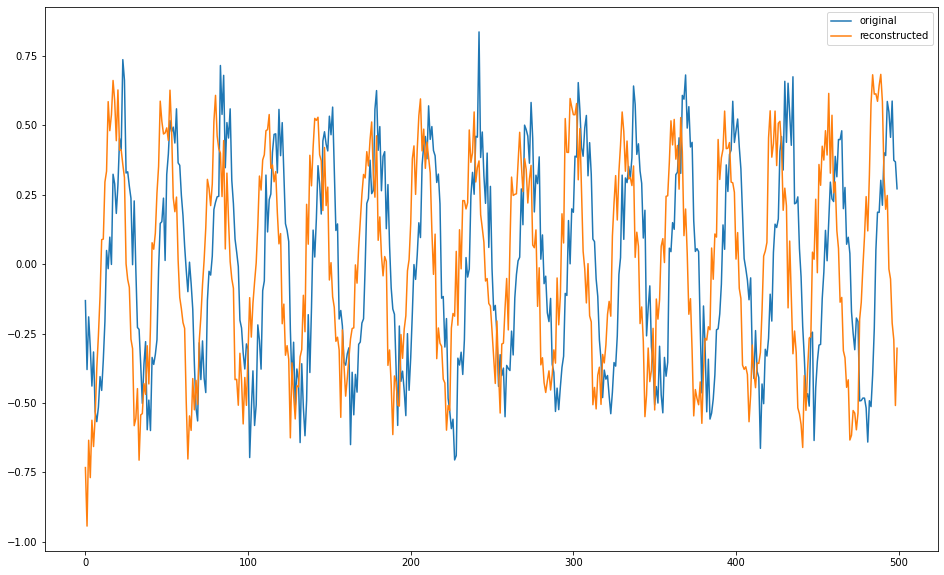

In [18]:
plt.figure(figsize=(16,10))
id = 40
plt.plot(np.arange(len(original[0,:,0])), original[id,:,0], label='original')
plt.plot(np.arange(len(reconstructed[0,:,0])), reconstructed[id,:,0],  label='reconstructed') 
plt.legend()
plt.show()

In [ ]:
# Replace a random segment with an anomaly to see how they compute the anomaly scores locally
data_few = data[:100] # just take a small part of the data as testing set
labels = np.zeros(100*4)
for i in range(data_few.shape[0]):
  ranIndex = np.random.randint(0,3)
  labels[i*4+ranIndex] = 1
  data_few[i,ranIndex*125:(ranIndex+1)*125,0] = np.random.normal(0,1,125)

In [ ]:
d_freq = signal_2_fourier(data_few)
anomaly_scores = fanogan.anomaly_per_segment(d_freq)

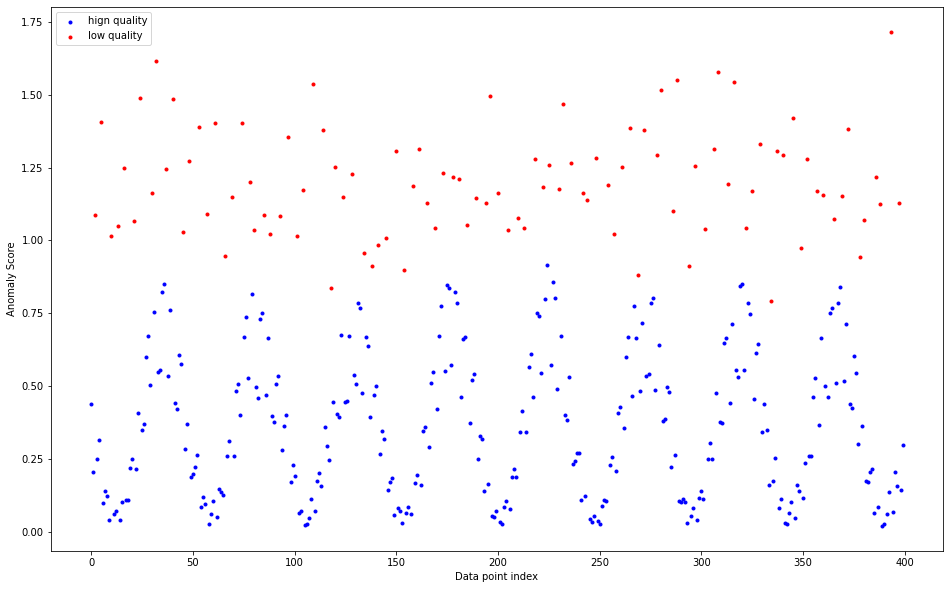

In [ ]:
# anomaly scores locally
scatter_GANs(labels, anomaly_scores)

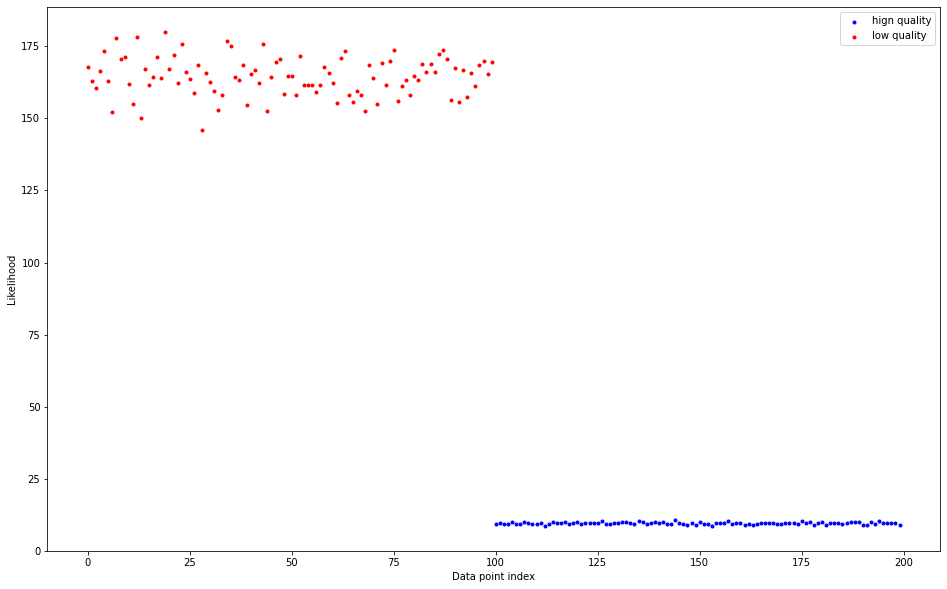

In [ ]:
# random as anomalies
y_lik_anom_f = fanogan.anomaly_score(anomalies_freq[0:100])
y_lik_normal_f = fanogan.anomaly_score(data_freq[0:100])
y_lik = np.concatenate((y_lik_anom_f, y_lik_normal_f))
y_true = np.ones(200)
y_true[100:] = 0
catter(y_true,y_lik)

*anoGAN*

In [20]:
anogan = ANOGAN(singan)

In [23]:
%%timeit
# time the anoGAN
anogan.anomaly_scores(np.expand_dims(data_freq[0],0))

1 loop, best of 3: 3.74 s per loop


In [24]:
%%timeit
# time the f-anoGAN
fanogan.anomaly_score(np.expand_dims(data_freq[0],0))

The slowest run took 6.11 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 32.6 ms per loop


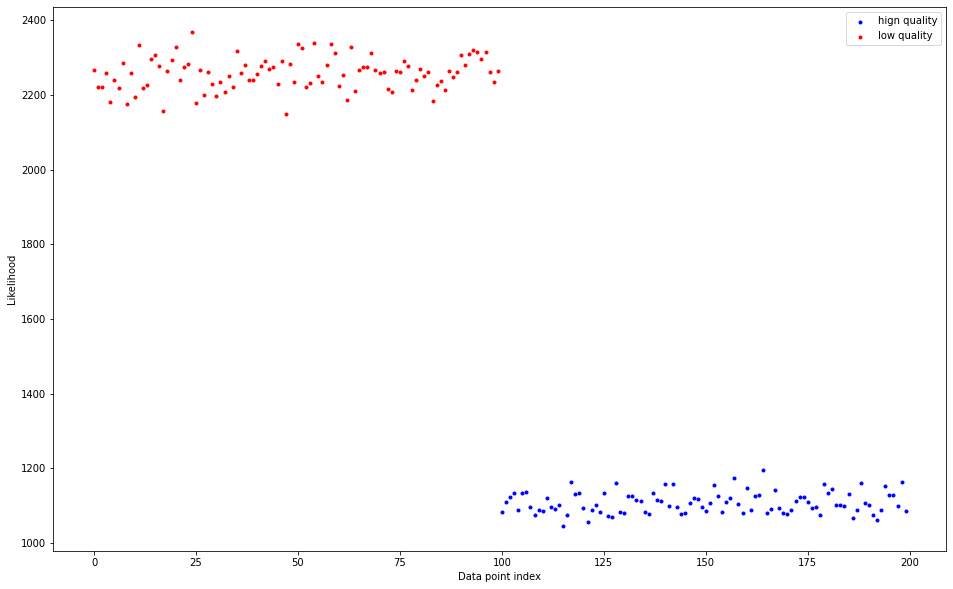

In [49]:
# random data as anomalies
anomalies_time_rand = np.random.uniform(0, 1, (500,500,1))
anomalies_freq_rand = signal_2_fourier(anomalies_time_rand)
y_lik_anom = anogan.anomaly_scores(anomalies_freq_rand[0:100])
y_lik_normal = anogan.anomaly_scores(data_freq[0:100])
y_lik = np.concatenate((y_lik_anom, y_lik_normal))
y_true = np.ones(200)
y_true[100:] = 0
scatter_GANs(y_true,y_lik)

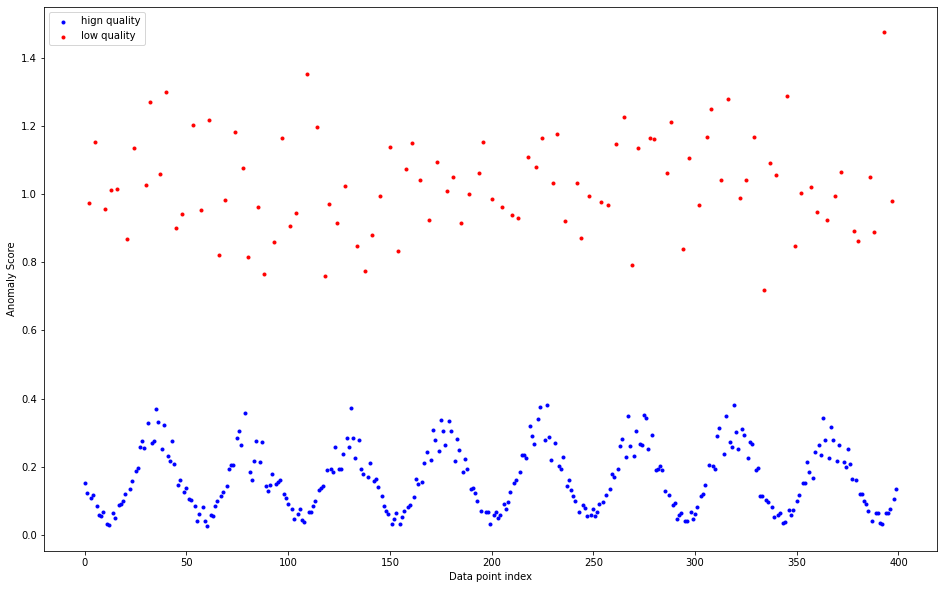

In [ ]:
# d_freq have anomalies per segment 
anomaly_scores_anoGAN = anogan.anomaly_per_segment(d_freq)
scatter_GANs(labels, anomaly_scores_anoGAN)

*Traditional GAN*

In [ ]:
gan = GAN(kernel=5, gen_layers=2, dis_layers=2, latentDim=100, depth=60, dil=1, 
          snippet_len=500, channels=1, dropout=0.3, INIT_LR=1e-5, DECAY=6e-8)

In [ ]:
gan.train(data, epochs=300, batch_size=256, noisy_labels=False, smoothen_labels=0.05)

3/7 [===========>..................] - ETA: 3:08

KeyboardInterrupt: ignored

In [ ]:
fake = gan.generate_fake_signals(10)

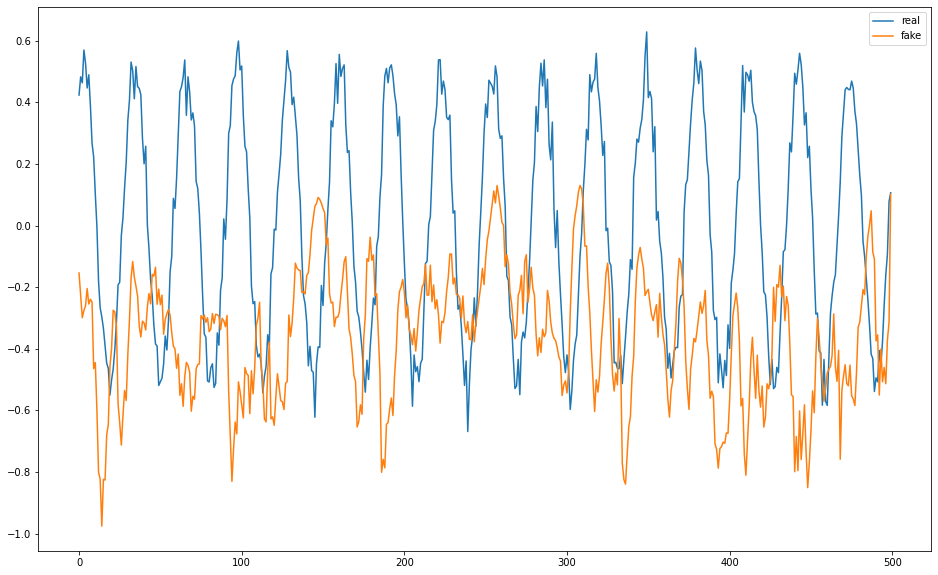

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(data.shape[1]), data[10,:,0], label='real')
plt.plot(np.arange(fake.shape[1]), fake[0,:,0], label='fake') 
plt.legend()
plt.show()

*TO DELETE*

In [ ]:
  
  # def inverse_mapping(self, x, a=1e-2):

  #   z = np.uniform(0, 1, self.gan.latentDim)

  #   for _ in range(self.gamma):

  #     # calculate gradients of G with respect to z_i
  #     x_tensor = tf.convert_to_tensor(z, dtype=tf.float32)
  #     with tf.GradientTape() as t:
  #         t.watch(x_tensor)
  #         output = G(x_tensor)

  #     gradients_G = t.gradient(output, x_tensor)

  #     # calculate gradients of f with respect to G(z_i)
  #     x_tensor = tf.convert_to_tensor(self.G(z), dtype=tf.float32)
  #     with tf.GradientTape() as t:
  #         t.watch(x_tensor)
  #         output = f(x_tensor)
          
  #     #################################
  #     gradients_f = tf.tensordot(t.gradient(output, x_tensor), gradients_G, 1)

  #     grad_loss = K.sign(x-self.G(z))*gradients_G + K.sign(f(x)-f(self.G(z)))*gradients_f

  #     z = z - a * grad_loss



  # def residual_loss(self, x, z):

  #   return K.sum(K.abs(x - self.G(z)))


  # def discriminator_loss(self, x, z):

  #   return K.sum(K.abs(self.f(x) - self.f(self.G(z))))

  
  # def loss(self, x, z):

  #   return (1-self.l)*self.residual_loss(x, z) + self.l*self.discriminator_loss(x,z)

  

In [ ]:
'''
Implementation of the f-anoGAN. After intializing it, we should call build_encoder to build the encoder and then train it.
gan: GAN in which the f-anoGAN will be based. It can be a limeGAN too.
freq: True if we use a limeGAN
'''
class FANOGAN:
  def __init__(self, gan, freq=False):

    self.gan = gan
    self.D = gan.D
    self.G = gan.G

    self.freq = freq # whether we use the LimeGAN

    self.kappa = None
    self.DF = None

    self.encoder = None
    self.autoencoder = None


  def save(self, filename):

    d = {
    'kernel' : self.gan.kernel,
    'gen_layers' : self.gan.gen_layers, 
    'dis_layers' : self.gan.dis_layers, 
    'latentDim' : self.gan.latentDim,
    'depth'  : self.gan.depth,
    'dil' :self.gan.dil,
    'snippet_len' : self.gan.snippet_len,
    'channels' : self.gan.channels,
    'dropout' : self.gan.dropout,
    'G_json' : self.gan.G.to_json(),
    'G_weights' : self.gan.G.get_weights(),
    'D_json' : self.gan.D_uncompiled.to_json(),
    'D_weights' : self.gan.D_uncompiled.get_weights(),
    'kappa' : self.kappa,
    'encoder_weights' : self.encoder.get_weights(),
    'encoder_json' : self.encoder.to_json(),
    'freq' : self.freq
    }
    
    dump(d, open(filename + '.model', 'wb'))
    


  @staticmethod
  def load(filename):

    d = load(open(filename + '.model', 'rb'))

    if d['freq']:
      gan = limeGAN(d['kernel'], d['gen_layers'], d['dis_layers'], d['latentDim'], 
              d['depth'], d['dil'], d['snippet_len'],  d['channels'], d['dropout'])
    else:
      gan = GAN(d['kernel'], d['gen_layers'], d['dis_layers'], d['latentDim'], 
              d['depth'], d['dil'], d['snippet_len'],  d['channels'], d['dropout'])
    

    G = model_from_json(d['G_json'])
    G.set_weights(d['G_weights'])
    gan.G = G

    D_uncompiled = model_from_json(d['D_json'])
    D_uncompiled.set_weights(d['D_weights'])
    gan.D_uncompiled = D_uncompiled

    gan.D = gan.discriminator_compiled(D_uncompiled)
    gan.Adversarial = gan.adversarial_model(G, D_uncompiled)

    fanogan = FANOGAN(gan, freq=d['freq'])

    fanogan.kappa = d['kappa']

    encoder = model_from_json(d['encoder_json'])
    encoder.set_weights(d['encoder_weights'])
    fanogan.encoder = encoder

    fanogan.build_autoencoder()
    fanogan.discriminator_features()

    return fanogan


  # We build the encoder of the f-anoGAN. We define the kernel size and how many layers  
  def build_encoder(self, kernel, layers, dil=1, dropout=None):

    latentDim = self.gan.latentDim
    snippet_len = self.gan.snippet_len
    channels = self.gan.channels

    if self.freq:
      snippet_len = snippet_len//2 + 1
      channels = 2*channels

    # initialize the input shape to be "channels last" along with the channels dimension itself
    inputShape = (snippet_len, channels)

    # define the input to the encoder
    inputs = Input(shape=inputShape)

    x = inputs
    # loop over the number of layers. At each layer we half the depth
    for i in range(layers):
      x = Conv1D(self.gan.depth//2**i, kernel, padding="same", dilation_rate=dil,
                #  kernel_regularizer='l1', bias_regularizer='l1',
                 )(x)
      x = ReLU()(x)

      if dropout != None:
        x = Dropout(dropout)(x)

    x = Flatten()(x)
    latent = Dense(latentDim, activation='sigmoid')(x)

    encoder = Model(inputs, latent)

    self.encoder = encoder
    self.build_autoencoder()


  # method is izi or ziz
  def build_autoencoder(self):

    encoder = self.encoder
    G = self.G

    G.trainable = False

    snippet_len = self.gan.snippet_len
    channels = self.gan.channels

    if self.freq:
      snippet_len = snippet_len//2 + 1
      channels = 2*channels

    inputs = Input(shape=(snippet_len, channels))
    x = self.encoder(inputs)
    outputs = G(x)
    self.autoencoder = Model(inputs, outputs)


  def anomaly_score(self, data, kappa=None):

    # reconstruction error
    predicted = self.autoencoder.predict(data)
    AR = np.mean((data-predicted)**2, axis=(1,2))

    if kappa is not None:
      # discriminator features
      f = self.DF
      f_x = f.predict(data)
      predicted_f_x = f.predict(predicted)
      AD = np.mean((f_x - predicted_f_x)**2)

      return AR + kappa*AD
    
    else:
      return AR
    
  #  snippet_len should be integer multiple of segment_len
  def anomaly_per_segment(self, data, segment_len=125):

    if self.freq:
      original = fourier_2_signal(data, self.gan.snippet_len)
      reconstructed = fourier_2_signal(self.autoencoder.predict(data), self.gan.snippet_len)
    else:
      original = data
      reconstructed = self.autoencoder.predict(data)

    original = original.reshape(-1, segment_len, self.gan.channels)
    reconstructed = reconstructed.reshape(-1, segment_len, self.gan.channels)

    errors = np.mean((original-reconstructed)**2, axis=(1,2))

    return errors



  
  def discriminator_features(self):
    self.DF = Model(inputs=self.D.layers[0].input, outputs=self.D.layers[-3].output)


  def discriminator_guided_loss(self, x, y):

      # AR = K.mean((x-y)**2)
      AR = K.mean(K.abs((x-y)))

      f_x = self.DF(x)
      f_y = self.DF(y)

      # AD = K.mean((f_x-f_y)**2)
      AD = K.mean(K.abs((f_x-f_y)))

      return AR + self.kappa*AD



  
  def train_autoencoder_izi(self, d_train, d_val, EPOCHS, b_size, kappa=None, INIT_LR=1e-4):

    DECAY = INIT_LR/EPOCHS

    opt = Adam(lr=INIT_LR, decay=DECAY)
    
    if kappa is None:
      self.autoencoder.compile(loss='mae', optimizer=opt)

      self.autoencoder.fit(x=d_train, y=d_train, batch_size=b_size, epochs=EPOCHS, validation_data=(d_val, d_val),
                      # steps_per_epoch=steps,  callbacks=callbacks_list, verbose=2
                      ) 
    
    else:

      self.kappa = kappa
      self.discriminator_features()

      self.autoencoder.compile(loss=self.discriminator_guided_loss, optimizer=opt)

      self.autoencoder.fit(x=d_train, y=d_train, batch_size=b_size, epochs=EPOCHS, validation_data=(d_val, d_val),
                      # steps_per_epoch=steps,  callbacks=callbacks_list, verbose=2
                      ) 
      
  
  def train_autoencoder_ziz(self, train_samples, val_samples, EPOCHS, b_size=128, INIT_LR=1e-4):

    DECAY = INIT_LR/EPOCHS
    opt = Adam(lr=INIT_LR, decay=DECAY)

    # create ziz model

    encoder = self.encoder
    G = self.G
    G.trainable = False

    inputs = Input(shape=(self.gan.latentDim))
    x = G(inputs)
    outputs = encoder(x)
    ziz_model = Model(inputs, outputs)

    ziz_model.compile(loss='mse', optimizer=opt)

    d_train = np.random.uniform(0, 1, (train_samples, self.gan.latentDim))
    d_val = np.random.uniform(0, 1, (val_samples, self.gan.latentDim))

    ziz_model.fit(x=d_train, y=d_train, batch_size=b_size, epochs=EPOCHS, validation_data=(d_val, d_val)) 


    # build autoencoder

    snippet_len = self.gan.snippet_len
    channels = self.gan.channels

    if self.freq:
      snippet_len = snippet_len//2 + 1
      channels = 2*channels

    inputs = Input(shape=(snippet_len, channels))
    x = ziz_model.layers[-1](inputs)
    outputs = self.G(x)
    self.autoencoder = Model(inputs, outputs)

In [ ]:
'''
anoGAN implementation
gan: GAN in which the f-anoGAN will be based. It can be a limeGAN too.
freq: True if we use a limeGAN
gamma: How many epochs we will use in each inverse mapping iteration
We don't need to save it because there is no learning. Saving the GAN is enough
'''
class ANOGAN:
  def __init__(self, gan, kappa=0.1, gamma=500, freq=True):
    self.gan = gan
    self.G = gan.G
    self.D = gan.D
    self.gamma = gamma
    self.kappa = kappa
    self.f = Model(inputs=self.D.layers[0].input, outputs=self.D.layers[-2].output)
    self.freq = freq

    self.snippet_len = self.gan.snippet_len
    self.channels = self.gan.channels
    self.latentDim = self.gan.latentDim

    if freq:
      self.snippet_len = self.snippet_len //2 + 1
      self.channels = self.channels * 2


  # anomaly score using a singe-layer NN for each sample, using the loss function defined in the anoGAN paper
  # It works in finding the correct inverse mapping (tested) and is actually quite fast, since it is using optimized code,
  # in comparison with my Python loop
  # Courtesy of https://github.com/yjucho1/anoGAN
  def build_anomaly_detector(self):

      G = self.G
      G.trainable = False

      intermidiate_model = self.f
      intermidiate_model.trainable = False
      
      aInput = Input(shape=(self.latentDim,))

      # project to latent space
      latent = Dense(self.gan.latentDim, 'sigmoid')(aInput)

      # pass through generator again
      G_out = G(latent)

      # discriminator features
      D_out= intermidiate_model(G_out)    
      model = Model(inputs=aInput, outputs=[G_out, D_out])

      model.compile(loss=sum_of_residual, loss_weights= [1-self.kappa, self.kappa], optimizer='adam')

      return model


  def compute_anomaly_score(self, x):    

    # initial approximation of z
    z = np.random.uniform(0, 1, size=(1, self.gan.latentDim))

    intermidiate_model = self.f

    x = np.expand_dims(x, axis=0)
    
    d_x = intermidiate_model.predict(x)

    d_x = np.expand_dims(d_x, axis=0)

    anomaly_detector = self.build_anomaly_detector()

    loss = anomaly_detector.fit(z, [x, d_x], epochs=self.gamma, verbose=0)
    similar_data, _ = anomaly_detector.predict(z)
    return loss.history['loss'][-1], similar_data


  #########################################################################
   # Inverse mapping as explained in the anoGAN paper (IT DOES NOT WORK)

  # def inverse_mapping(self, x, a=1e-5):

  #   x = np.expand_dims(x, 0)

  #   z = np.random.uniform(0, 1, (1, self.gan.latentDim))

  #   for _ in range(1000):

  #     # calculate gradients of loss with respect to z
  #     z_tensor = tf.convert_to_tensor(z, dtype=tf.float32)
  #     with tf.GradientTape(watch_accessed_variables=False) as t:
  #         t.watch(z_tensor)

  #         output = (1-self.kappa) * tf.math.reduce_sum(tf.math.abs(x - self.G(z_tensor))) + \
  #         self.kappa * tf.math.reduce_sum(tf.math.abs(self.f(x) - self.f(self.G(z_tensor)))) # 

  #     grad_loss = t.gradient(output, z_tensor)

  #     z = z - a * grad_loss
    
  #   loss =  (1-self.kappa) * tf.math.reduce_sum(tf.math.abs(x - self.G(z))) + \
  #         self.kappa * tf.math.reduce_sum(tf.math.abs(self.f(x) - self.f(self.G(z))))\

  #   return loss, z


 #########################################################################     


  #  snippet_len should be integer multiple of segment_len
  def anomaly_per_segment(self, data, segment_len=125):

    if self.freq:
      original = fourier_2_signal(data, self.gan.snippet_len)

      reconstructed_fourier = np.zeros(data.shape)
      for i in range(data.shape[0]):
        reconstructed_fourier[i] =  self.compute_anomaly_score(data[i])[1]

      reconstructed = fourier_2_signal(reconstructed_fourier, self.gan.snippet_len)

    else:
      original = data

      reconstructed = np.zeros(data.shape)
      for i in range(data.shape[0]):
        reconstructed[i] =  self.compute_anomaly_score(data[i])[1]


    original = original.reshape(-1, segment_len, self.gan.channels)
    reconstructed = reconstructed.reshape(-1, segment_len, self.gan.channels)

    errors = np.mean((original-reconstructed)**2, axis=(1,2))

    return errors

  def anomaly_scores(self, data):

    scores = np.zeros(data.shape[0])

    for i in range(data.shape[0]):
      scores[i] =  self.compute_anomaly_score(data[i])[0] #  self.inverse_mapping(x)[0] # 

    return scores



In [ ]:
class GAN:
  def __init__(self, kernel, gen_layers, dis_layers, latentDim, depth, dil=1, 
               snippet_len=125,  channels=4, dropout=None, INIT_LR=1e-5, DECAY=6e-8):

    self.kernel = kernel
    self.gen_layers = gen_layers
    self.dis_layers = dis_layers
    self.latentDim = latentDim
    self.depth = depth
    self.dil = dil
    self.snippet_len = snippet_len
    self.channels = channels
    self.dropout = dropout


    self.INIT_LR = INIT_LR
    self.DECAY = DECAY

    self.G = self.generator()
    self.D_uncompiled = self.discriminator()

    self.D = self.discriminator_compiled(self.D_uncompiled)
    self.Adversarial = self.adversarial_model(self.G, self.D_uncompiled)


  def generator(self):

      inputs = Input(shape=(self.latentDim,))

      x = Dense(self.snippet_len * self.depth)(inputs)

      x = Reshape((self.snippet_len, self.depth))(x)

      # loop over our number of filters again, but this time in reverse order
      for i in range(self.gen_layers):
        x = Conv1DTranspose(self.depth*2**i, self.kernel, padding="same", dilation_rate=self.dil, #strides=2,
                            # kernel_regularizer='l1', bias_regularizer='l1',
                            )(x)
        x = ReLU()(x)
        # x = MaxPool1D(2)(x)

        # x = BatchNormalization()(x)
        
        if self.dropout != None:
          x = Dropout(self.dropout)(x)

      # apply a single CONV_TRANSPOSE layer used to recover the original depth of the signal
      x = Conv1DTranspose(self.channels, self.kernel, padding="same", dilation_rate=self.dil)(x)
      # outputs = K.tanh(x)
      outputs = x
      
      # build the generator model
      generator = Model(inputs, outputs, name="generator")

      return generator


  def discriminator(self):

    inputs = Input(shape=(self.snippet_len, self.channels))
    x = inputs

    # loop over our number of filters again, but this time in reverse order
    for i in range(self.dis_layers):
      x = Conv1D(self.depth*2**i, self.kernel, padding="same", dilation_rate=self.dil, 
                          # kernel_regularizer='l1', bias_regularizer='l1',
                          )(x)
      x = PReLU()(x)

      # x = BatchNormalization()(x)
      
      if self.dropout != None:
        x = Dropout(self.dropout)(x)


    x = Flatten()(x)

    outputs = Dense(1,activation='sigmoid')(x)

    discriminator = Model(inputs, outputs, name="discriminator")

    return discriminator


  
  def discriminator_compiled(self, D):
    opt = Adam(lr=self.INIT_LR, decay=self.DECAY)
    D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return D


  def adversarial_model(self, G, D):

    opt = Adam(lr=self.INIT_LR, decay=self.DECAY)
    D.trainable = False
    AM = Sequential()
    AM.add(G)
    AM.add(D)
    AM.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return AM


  def save(self, filename):
    d = {
        'kernel' : self.kernel,
        'gen_layers' : self.gen_layers, 
        'dis_layers' : self.dis_layers, 
        'latentDim' : self.latentDim,
        'depth'  : self.depth,
        'dil' :self.dil,
        'snippet_len' : self.snippet_len,
        'INIT_LR' : self.INIT_LR,
         'DECAY' : self.DECAY,
        'channels' : self.channels,
        'dropout' : self.dropout,
         'G_json' : self.G.to_json(),
         'G_weights' : self.G.get_weights(),
          'D_json' : self.D_uncompiled.to_json(),
         'D_weights' : self.D_uncompiled.get_weights()
         }

    dump(d, open(filename + '.model', 'wb'))

  
  @staticmethod
  def load(filename):
    d = load(open(filename + '.model', 'rb'))

    gan = GAN(d['kernel'], d['gen_layers'], d['dis_layers'], d['latentDim'], 
              d['depth'], d['dil'], d['snippet_len'],  d['channels'], d['dropout'], d['INIT_LR'], d['DECAY'])
    

    G = model_from_json(d['G_json'])
    G.set_weights(d['G_weights'])
    gan.GAN = G

    D_uncompiled = model_from_json(d['D_json'])
    D_uncompiled.set_weights(d['D_weights'])
    gan.D_uncompiled = D_uncompiled

    gan.D = gan.discriminator_compiled(D_uncompiled)
    gan.Adversarial = gan.adversarial_model(G, D_uncompiled)

    return gan


  ### generate images
  def generate_fake_signals(self, n_samples):
    noise = np.random.uniform(0, 1, (n_samples, self.latentDim))
    generated_signals = self.G.predict(noise)
    return generated_signals



  def train(self, train_set, epochs, batch_size, noisy_labels=False, smoothen_labels=0):

    batches = train_set.shape[0]//batch_size
    progress_bar = Progbar(target=batches)

    if smoothen_labels != 0:
      l = tf.keras.losses.BinaryCrossentropy(label_smoothing=smoothen_labels)
      opt = Adam(lr=self.INIT_LR, decay=self.DECAY)
      self.Adversarial.compile(loss=l, optimizer=opt, metrics=['accuracy'])
      self.D.compile(loss=l, optimizer=opt, metrics=['accuracy'])


    for epoch in range(epochs):
      
      train_set = shuffle(train_set)

      # TRAIN
      for idx in range(batches):

        # take batch_size number of real signals
        signals_real = train_set[idx*batch_size : (idx+1)*batch_size, :, :]
        
        # generate batch_size number of fake signals
        noise = np.random.uniform(0, 1, size=[batch_size, self.latentDim])
        signals_fake = self.G.predict(noise)

        x = np.concatenate((signals_real, signals_fake))

        if noisy_labels:
          y = np.random.uniform(0.7, 1.0, (2*batch_size, 1))
          y[batch_size:, :] = np.random.uniform(0, 0.3, (batch_size, 1))
        else:  
          y = np.ones([2*batch_size, 1])
          y[batch_size:, :] = 0

        # train discriminator
        d_loss = self.D.train_on_batch(x, y)

        # train adversarial model
        if noisy_labels:
          y = np.random.uniform(0.7, 1.0, (batch_size, 1))
        else:
          y = np.ones([batch_size, 1])

        noise = np.random.uniform(0, 1, size=[batch_size, self.latentDim])
        a_loss = self.Adversarial.train_on_batch(noise, y)

        progress_bar.update(idx)


      log_mesg = ' EPOCH %d: [D loss: %f, acc: %f]   [A loss: %f, acc: %f]' % (epoch, d_loss[0], d_loss[1], a_loss[0], a_loss[1])
      print(log_mesg)
  
      # every 10 epochs save an example
      if epoch % 10 == 0:
        fake = self.generate_fake_signals(4)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
        ax1.plot(np.arange(fake.shape[1]), fake[0])
        ax2.plot(np.arange(fake.shape[1]), fake[1])
        ax3.plot(np.arange(fake.shape[1]), fake[2])
        ax4.plot(np.arange(fake.shape[1]), fake[3])
        plt.savefig('GANs/SineGAN/'+str(epoch) + '.png')
        plt.close()




In [ ]:
# transform a complex number from polar to cartesian coordinates
def polar2cartesian(radii, angles):
    return radii * np.exp(1j*angles)

# transform a complex number from cartesian to polar coordinates
def cartesian2polar(x):
    return np.abs(x), np.angle(x)

# It takes as input a signal in the time domain (shape (-1, snippet_len, channels))
# and returns it in the frequency domain as in the output of the limeGAN (shape (-1, snippet_len//2+1, 2*channels))
def signal_2_fourier(signal):
  # freq = np.fft.fft(signal, axis=1)
  freq = np.fft.rfft(signal, axis=1)

  radii, angles = cartesian2polar(freq)

  # we have that angle and radius are symmetric if we exclude element 0
  # radii = radii[:,:signal.shape[1]//2+1,:]
  # angles = angles[:,:signal.shape[1]//2+1,:]

  output = np.concatenate((radii, angles), axis=2)

  return output

# Inverse of the previous operation. From the output of the limeGAN to a signal in the time domain
def fourier_2_signal(freq, length):

  radii = freq[:,:,:freq.shape[2]//2]
  angles = freq[:,:,freq.shape[2]//2:]

  # unravel the symmetry (-1,125,4)
  # radii = np.concatenate((radii, np.flip(radii[:,1:,:], axis=1)), axis=1)
  # angles = np.concatenate((angles, -1*np.flip(angles[:,1:,:], axis=1)), axis=1)

  # (-1,125,4)
  cartesian = polar2cartesian(radii, angles)

  # signal = np.fft.ifft(cartesian, axis=1)
  signal = np.fft.irfft(cartesian, n=length, axis=1)


  return signal

In [ ]:
# used in output of the generator of the limeGAN
def custom_activation(x):

  channels = K.shape(x)[2]
  r = x[:,:,:channels//2]
  a = x[:,:,channels//2:]

  r = K.abs(r)  # radius cannot be negative

  a = K.tanh(a) * K.constant(np.pi)   # angle between -pi and pi

  out = K.concatenate((r, a), axis=2)

  return out


In [ ]:
# Scatter plot that we use for the anomalies. The only thing that changes is the ylablel
# y_likelihoods is the anomaly score
def scatter_GANs(y_true, y_likelihoods):

  good_indices = np.where(y_true == 0)[0]
  bad_indices = np.where(y_true == 1)[0]
  good_points = y_likelihoods[good_indices]
  bad_points = y_likelihoods[bad_indices]

  plt.figure(figsize=(16,10))
  plt.scatter(good_indices, good_points, label='hign quality', c='b', marker='.')
  plt.scatter(bad_indices, bad_points, label='low quality', c='r', marker='.')
  # plt.ylim(0,10000)
  plt.ylabel("Anomaly Score")
  plt.xlabel("Data point index")

  plt.legend()
  plt.show()

In [ ]:
'''
Initialization of the limeGAN. It contains a G and a D, both convolutional. For simplicity, the kernel size is the same everywhere.
kernel: kernel size (int)
gen_layers: layers of generator (int)
dis_layers: layers of discriminator (int)
latentDim: dimension of the latent space (int)
depth: After the latent vector generation, we initialize a depth as a second dimension which will be decreased by layer and 
will end up being the channel dimension (int)
dil: dilation rate
snippet_len: length of the segment we will generate
channels: the number of the channels
dropout: the dropout rate that will be used at each layer
INIT_LR: initial learning rate. We use the same in G and D
DECAY: weight decay. We use the same in G and D
''' 
class limeGAN:
  def __init__(self, kernel, gen_layers, dis_layers, latentDim, depth, dil=1, snippet_len=125,  
               channels=4, dropout=None, INIT_LR=1e-5, DECAY=6e-8):

    self.kernel = kernel
    self.gen_layers = gen_layers
    self.dis_layers = dis_layers
    self.latentDim = latentDim
    self.depth = depth
    self.dil = dil
    self.snippet_len = snippet_len
    self.channels = channels
    self.dropout = dropout

    self.INIT_LR = INIT_LR
    self.DECAY = DECAY

    self.G = self.generator()
    self.D_uncompiled = self.discriminator()

    self.D = self.discriminator_compiled(self.D_uncompiled)
    self.Adversarial = self.adversarial_model(self.G, self.D_uncompiled)


  '''
  It saves the GAN to storage in the file "filename.model"
  '''
  def save(self, filename):
    d = {
        'kernel' : self.kernel,
        'gen_layers' : self.gen_layers, 
        'dis_layers' : self.dis_layers, 
        'latentDim' : self.latentDim,
        'depth'  : self.depth,
        'dil' :self.dil,
         'INIT_LR' : self.INIT_LR,
         'DECAY' : self.DECAY,
        'snippet_len' : self.snippet_len,
        'channels' : self.channels,
        'dropout' : self.dropout,
         'G_json' : self.G.to_json(),
         'G_weights' : self.G.get_weights(),
          'D_json' : self.D_uncompiled.to_json(),
         'D_weights' : self.D_uncompiled.get_weights()
         }

    dump(d, open(filename + '.model', 'wb'))

  '''
  Static method. We can load a limeGAN saved using the previous method.
  '''
  @staticmethod
  def load(filename):
    d = load(open(filename + '.model', 'rb'))

    gan = limeGAN(d['kernel'], d['gen_layers'], d['dis_layers'], d['latentDim'], 
              d['depth'], d['dil'], d['snippet_len'],  d['channels'], d['dropout'], d['INIT_LR'], d['DECAY'])
    

    G = model_from_json(d['G_json'])
    G.set_weights(d['G_weights'])
    gan.G = G

    D_uncompiled = model_from_json(d['D_json'])
    D_uncompiled.set_weights(d['D_weights'])
    gan.D_uncompiled = D_uncompiled

    gan.D = gan.discriminator_compiled(D_uncompiled)
    gan.Adversarial = gan.adversarial_model(G, D_uncompiled)

    return gan


  # It generates signals in the frequency domain as explained in the report
  def generator(self):

      output_len = self.snippet_len//2+1    

      inputs = Input(shape=(self.latentDim,))

      x = Dense(output_len * self.depth)(inputs) 

      x = Reshape((output_len, self.depth))(x) 

      # loop over our number of layers. The number of unitis is decreased until we reach a number equal to the channels number (x2)
      for i in range(self.gen_layers):
        x = Conv1DTranspose(self.depth*2**i, self.kernel, padding="same", dilation_rate=self.dil,
                            # kernel_regularizer='l1', bias_regularizer='l1',
                            )(x)
        x = ReLU()(x)
        # x = MaxPool1D(2)(x)

        # x = BatchNormalization()(x)
        
        if self.dropout != None:
          x = Dropout(self.dropout)(x)

      # apply a single CONV_TRANSPOSE layer used to recover the original depth of the signal
      x = Conv1DTranspose(self.channels*2, self.kernel, padding="same", dilation_rate=self.dil)(x) ###########

      outputs = custom_activation(x)

      # build the generator model
      generator = Model(inputs, outputs, name="generator")

      return generator


  def discriminator(self):

    input_len = self.snippet_len//2+1   

    inputs = Input(shape=(input_len, 2*self.channels))
    x = inputs

    # loop over our number of layers. At each step we increase the number of units
    for i in range(self.dis_layers):
      x = Conv1D(self.depth*2**i, self.kernel, padding="same", dilation_rate=self.dil, 
                          # kernel_regularizer='l1', bias_regularizer='l1',
                          )(x)
      x = PReLU()(x)

      # x = BatchNormalization()(x)
      
      if self.dropout != None:
        x = Dropout(self.dropout)(x)


    x = Flatten()(x)

    outputs = Dense(1,activation='sigmoid')(x)

    discriminator = Model(inputs, outputs, name="discriminator")

    return discriminator


  # we compile the D. We also need it uncompiled in order to compile it in the adversarial model (with the G)
  def discriminator_compiled(self, D):
    opt = Adam(lr=self.INIT_LR, decay=self.DECAY)
    D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return D

  # adversarial model. G and D together but only G is trainable
  def adversarial_model(self, G, D):

    opt = Adam(lr=self.INIT_LR, decay=self.DECAY)
    D.trainable = False
    AM = Sequential()
    AM.add(G)
    AM.add(D)
    AM.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return AM


  # We generate fake signals. The output of the G is transformed on the time domain
  def generate_fake_signals(self, n_samples):

    noise = np.random.uniform(0, 1, (n_samples, self.latentDim))
    generated = self.G.predict(noise)

    signal = fourier_2_signal(generated, self.snippet_len)
    return signal

  # train the GAN
  # We can implement noisy_labels and smoothen labels in a non-noisy manner. We can also save plots 
  #of examples of generated signals in savepath directory
  def train(self, train_set, epochs, batch_size, noisy_labels=False, smoothen_labels=0, savepath='GANs/LogSinGANfreq/'):

    batches = train_set.shape[0]//batch_size
    progress_bar = Progbar(target=batches)

    if smoothen_labels != 0:
      l = tf.keras.losses.BinaryCrossentropy(label_smoothing=smoothen_labels)
      opt = Adam(lr=self.INIT_LR, decay=self.DECAY)
      self.Adversarial.compile(loss=l, optimizer=opt, metrics=['accuracy'])
      self.D.compile(loss=l, optimizer=opt, metrics=['accuracy'])

    for epoch in range(epochs):
      
      train_set = shuffle(train_set)

      # TRAIN
      for idx in range(batches):

        # take batch_size number of real signals
        signals_real = train_set[idx*batch_size : (idx+1)*batch_size, :, :]
        
        # generate batch_size number of fake signals
        noise = np.random.uniform(0, 1, size=[batch_size, self.latentDim])
        signals_fake = self.G.predict(noise)

        x = np.concatenate((signals_real, signals_fake))

        if noisy_labels:
          y = np.random.uniform(0.7, 1.0, (2*batch_size, 1))
          y[batch_size:, :] = np.random.uniform(0, 0.3, (batch_size, 1))
        else:  
          y = np.ones([2*batch_size, 1])
          y[batch_size:, :] = 0

        # train discriminator
        d_loss = self.D.train_on_batch(x, y)

        # train adversarial model
        if noisy_labels:
          y = np.random.uniform(0.7, 1.0, (batch_size, 1))
        else:
          y = np.ones([batch_size, 1])


        noise = np.random.uniform(0, 1, size=[batch_size, self.latentDim])
        a_loss = self.Adversarial.train_on_batch(noise, y)

        progress_bar.update(idx)


      # every 10 epochs save an example
      if epoch % 10 == 0 and savepath != None:
        fake = self.generate_fake_signals(4)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
        ax1.plot(np.arange(fake.shape[1]), fake[0])
        ax2.plot(np.arange(fake.shape[1]), fake[1])
        ax3.plot(np.arange(fake.shape[1]), fake[2])
        ax4.plot(np.arange(fake.shape[1]), fake[3])
        plt.savefig(savepath + str(epoch) + '.png')
        plt.close()

      log_mesg = ' EPOCH %d: [D loss: %f, acc: %f]   [A loss: %f, acc: %f]' % (epoch, d_loss[0], d_loss[1], a_loss[0], a_loss[1])
      print(log_mesg)
  
  
